In [11]:
import pandas as pd
import numpy as np

In [12]:
mapping = pd.read_csv("../csv_files/bookstore_csv/mapping.csv")
d_type = {"commit_hash" : "str", 	"num_additions" : int,	"num_deletions": int, "filename" : "str"}

def load_data(file):
    df = pd.read_csv(file)
    df = df[df.filename.str.endswith(".java")]
    return pd.DataFrame({"commit_hash": df.commit_hash, "changes": pd.to_numeric(df.num_additions) + pd.to_numeric(df.num_deletions), "filename": df.filename})

data_java = load_data("../csv_files/bookstore_csv/output_java.csv")
data_ast = load_data("../csv_files/bookstore_csv/output_ast.csv")

In [13]:
mapping

,from,to
0,8a3399aec8341c0766a49826a023bb6b24562ec1,be9474a1320a2585581151aa211cf662595f593e
1,a1e77a023e1449d6f1d6bb4fc321e537c1c91432,566fe922671b6a1941400d381e63ce20c04d953a
2,7ee02cf2e1405fb376a7f0d9f10c53628ba18373,1c0a15bde391be864031fabdfb0389a2d5e5d8df
3,9f0a5c0e2efd594dfc93a7440f8965860b0fcfe0,ae9b5426c6c3da90531945dd539dee95f7a35cff
4,38443e531a68d35f9c3be2fcdbe749b3da232963,130f2baf932c7ea9c2885581b92b420091c7ce63
...,...,...
190,59e4f86a4d265dd166aaabb5fd3277b07668881f,29db0fdb898d8e9a67ba6d9d606f2e8e7bcf26b0
191,04bfbd44fc64324dceab22b069c90bb723ea9c49,e9d12bae3cc9fd9c856575e3f15a180b4ab37dc7
192,7f69dcee1135798e8b06e2fbf8539f7f04adb6d6,673aaee97c59baaccc653a37e6989bd01297e78c
193,011fad3dc5cd82ee511b196130f5ea7b54cc6ea0,c8876b959f65f3eedcc4b35700398d8aaece0452


In [14]:
data_ast

,commit_hash,changes,filename
0,c8876b959f65f3eedcc4b35700398d8aaece0452,21,src/main/java/com/bittercode/util/StoreUtil.java
1,c8876b959f65f3eedcc4b35700398d8aaece0452,18,src/main/java/servlets/CartServlet.java
2,c8876b959f65f3eedcc4b35700398d8aaece0452,114,src/main/java/servlets/ViewBookServlet.java
8,29db0fdb898d8e9a67ba6d9d606f2e8e7bcf26b0,435,src/main/java/com/bittercode/util/StoreUtil.java
9,29db0fdb898d8e9a67ba6d9d606f2e8e7bcf26b0,200,src/main/java/servlets/AboutServlet.java
...,...,...,...
532,566fe922671b6a1941400d381e63ce20c04d953a,450,OnlineBookStore/src/test/ReceiptServlet.java
533,566fe922671b6a1941400d381e63ce20c04d953a,208,OnlineBookStore/src/test/RemoveBookServlet.java
534,566fe922671b6a1941400d381e63ce20c04d953a,240,OnlineBookStore/src/test/UserLoginServlet.java
535,566fe922671b6a1941400d381e63ce20c04d953a,313,OnlineBookStore/src/test/UserRegisterServlet.java


In [15]:
data_java

,commit_hash,changes,filename
0,011fad3dc5cd82ee511b196130f5ea7b54cc6ea0,25,src/main/java/com/bittercode/util/StoreUtil.java
1,011fad3dc5cd82ee511b196130f5ea7b54cc6ea0,20,src/main/java/servlets/CartServlet.java
2,011fad3dc5cd82ee511b196130f5ea7b54cc6ea0,65,src/main/java/servlets/ViewBookServlet.java
8,59e4f86a4d265dd166aaabb5fd3277b07668881f,105,src/main/java/com/bittercode/util/StoreUtil.java
9,59e4f86a4d265dd166aaabb5fd3277b07668881f,35,src/main/java/servlets/AboutServlet.java
...,...,...,...
540,a1e77a023e1449d6f1d6bb4fc321e537c1c91432,75,OnlineBookStore/src/test/ReceiptServlet.java
541,a1e77a023e1449d6f1d6bb4fc321e537c1c91432,39,OnlineBookStore/src/test/RemoveBookServlet.java
542,a1e77a023e1449d6f1d6bb4fc321e537c1c91432,42,OnlineBookStore/src/test/UserLoginServlet.java
543,a1e77a023e1449d6f1d6bb4fc321e537c1c91432,47,OnlineBookStore/src/test/UserRegisterServlet.java


In [16]:
df_ast = pd.merge(data_ast, mapping, left_on="commit_hash", right_on="to", validate="m:1", how="left").rename(columns = {"from": "commit_hash", "commit_hash": "commit_hash_ast","changes": "changes_ast"}).drop(columns=["to"]).set_index(["commit_hash", "filename"])
df_ast.changes_ast

commit_hash                               filename                                         
011fad3dc5cd82ee511b196130f5ea7b54cc6ea0  src/main/java/com/bittercode/util/StoreUtil.java      21
                                          src/main/java/servlets/CartServlet.java               18
                                          src/main/java/servlets/ViewBookServlet.java          114
59e4f86a4d265dd166aaabb5fd3277b07668881f  src/main/java/com/bittercode/util/StoreUtil.java     435
                                          src/main/java/servlets/AboutServlet.java             200
                                                                                              ... 
a1e77a023e1449d6f1d6bb4fc321e537c1c91432  OnlineBookStore/src/test/ReceiptServlet.java         450
                                          OnlineBookStore/src/test/RemoveBookServlet.java      208
                                          OnlineBookStore/src/test/UserLoginServlet.java       240
                 

In [17]:
df_java = data_java.set_index(["commit_hash", "filename"])


In [18]:
df_merged = pd.merge(df_java, df_ast, left_index=True, right_index=True, validate="1:1", how="left").fillna(0, downcast="int64")
df_merged.isna().sum()

changes            0
commit_hash_ast    0
changes_ast        0
dtype: int64

<Axes: >

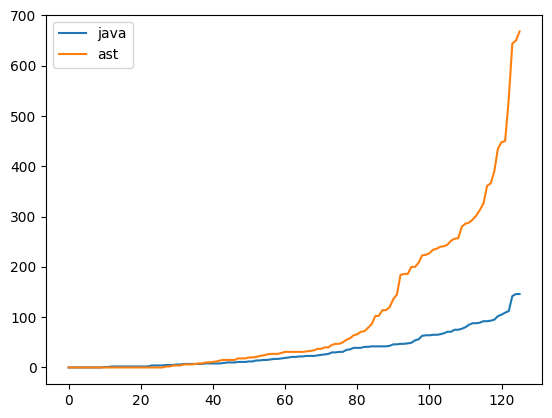

In [36]:
df = pd.DataFrame({"java": np.array(df_merged.changes.sort_values()), "ast": np.array(df_merged.changes_ast.sort_values())})
df.plot()

<Axes: >

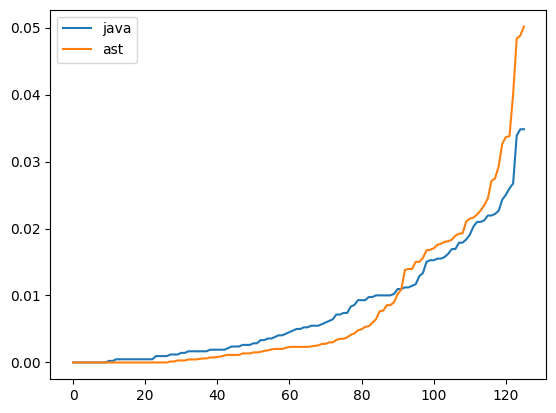

In [34]:
df = pd.DataFrame({"java": np.array(df_merged.changes.sort_values()), "ast": np.array(df_merged.changes_ast.sort_values())})
(df / df.sum()).plot()

<Axes: >

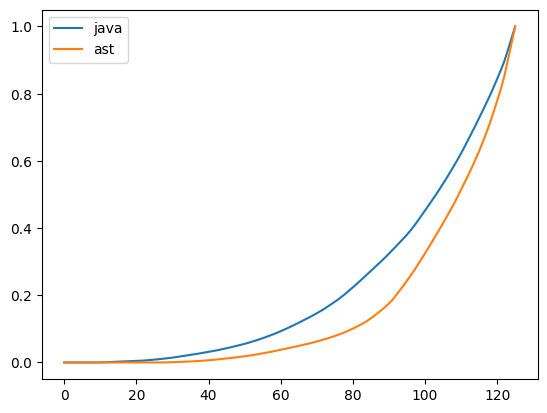

In [35]:
df = pd.DataFrame({"java": np.array(df_merged.changes.sort_values()), "ast": np.array(df_merged.changes_ast.sort_values())})
(df.cumsum() / df.sum()).plot()

<Axes: >

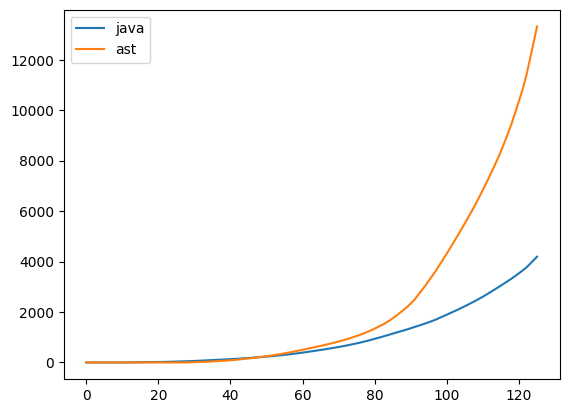

In [37]:
df = pd.DataFrame({"java": np.array(df_merged.changes.sort_values()), "ast": np.array(df_merged.changes_ast.sort_values())})
df.cumsum().plot()

<Axes: xlabel='commit_hash,filename'>

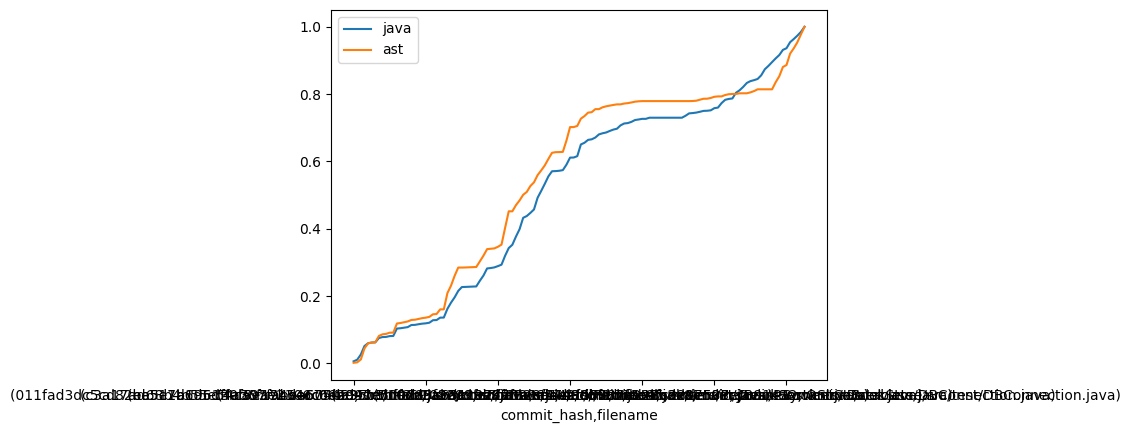

In [33]:
df = pd.DataFrame({"java": df_merged.changes, "ast": df_merged.changes_ast})
(df.cumsum() / df.sum()).plot()

In [27]:
#find størrelsen af filen for at finde en relativ ændring 
(df_merged == 0).sum()  

changes            10
commit_hash_ast    14
changes_ast        27
dtype: int64